In [19]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import requests
url = 'https://county.milwaukee.gov/EN/County-Clerk/Off-Nav/Election-Results/Election-Results-Fall-2020'

In [21]:
headers = {'User-Agent': "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 "
           "(KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36"}
r = requests.get(url, headers=headers)

In [22]:
from bs4 import BeautifulSoup as bs

In [31]:
bs_data = bs(r.text, 'html.parser')

In [24]:
precincts = bs_data.findAll('table', {'class': 'precinctTable'})

In [25]:
# presidential election on 1st precinctTable
precinct = precincts[1]
dataset = pd.DataFrame()

# split by table rows
for tr in precinct.find_all('tr'):
    
    lines = tr.text.split('\n')
    
    # second column is ward name
    ward_name = lines[2]

    # Header line
    if ward_name == "Ward":
        for line in lines[3:]:
            dataset[line] = 0    
    else:
        
        # append row
        new_row = {}
        for i in range(len(dataset.columns)):
            col = dataset.columns[i]
            value = lines[3+i]
            new_row[col] = value

        dataset = dataset.append(pd.Series(new_row, name=ward_name))


In [26]:
unstacked_data = dataset.unstack().reset_index().rename(
columns={0: 'count', 'level_0': 'candidate', 'level_1': 'ward'}
)

In [27]:
unstacked_data.head()

,candidate,ward,count
0,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 1,974
1,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 2,323
2,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 3,718
3,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 4,1257
4,Joseph R. Biden / Kamala D. Harris,City of Milwaukee Ward 5,660


Text(0.5, 0.98, 'Milwaukee Wards, N=479')

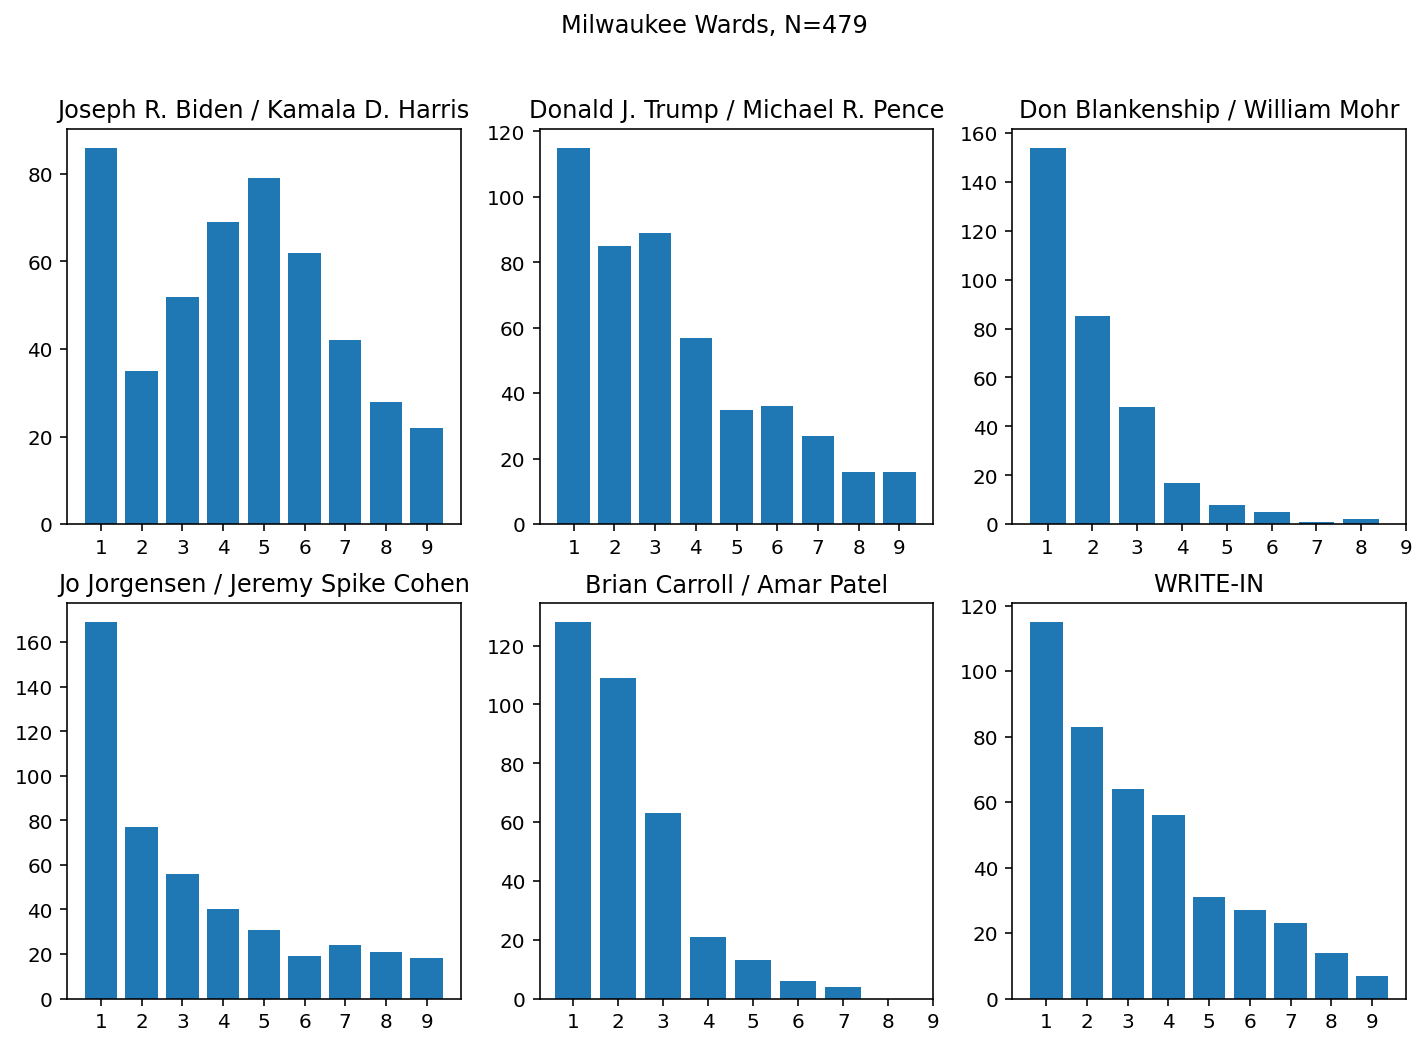

In [30]:

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
axs = np.array(axs).flatten()
candidates = unstacked_data.candidate.unique()

for i in range(len(axs)):

    ax = axs[i]
    candidate = candidates[i]
    cur_data = unstacked_data
    cur_data = cur_data.groupby(['candidate', 'ward']).sum()
    digits = cur_data.loc[candidate]['count'].astype(str).str[0].astype(int)
    digits = digits[digits > 0]
    
    v = digits.value_counts()
    ax.bar(v.index, v.values)
    ax.set_xticks(range(1, 10))

    ax.set_title("%s" % (candidate))

plt.suptitle("Milwaukee Wards, N=%d" % len(dataset))
    